###Detectron2 Fine-Tuned Over PubLayNet

Before Starting, download the model checkpoints for the model you want to use and save it locally/on drive from the following link: https://drive.google.com/drive/folders/11BeTAb8BlS9DiEb_ndoAh1fKyq16i6FC



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Installing Detectron2 in colab environment

In [ ]:
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")

Cloning into 'detectron2'...
remote: Enumerating objects: 15243, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 15243 (delta 136), reused 174 (delta 101), pack-reused 14979
Receiving objects: 100% (15243/15243), 6.27 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (11003/11003), done.


Install Dependencies,Set up the path for Detectron2

In [ ]:
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=1834f92d054cd53b00691b16bf815114366f6084f7cff7eccabc6f9148b9ad58
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=0666b82ea6e9a665a94757365035edc07ce133003d482679e3126ea351a0a240
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127e

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image as image_main
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [ ]:
image_path = '/content/paper-image.jpg'
model_path = '/content/drive/MyDrive/mask_rcnn_R_50_FPN_3x/model_final.pth'
model_zoo_config_name = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
prediction_score_threshold = 0.7
class_labels = ['text', 'title', 'list', 'table', 'figure']

Configure the Detectron2 model for inference

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_zoo_config_name))
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = prediction_score_threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

Detectron2 predictor

In [ ]:
predictor = DefaultPredictor(cfg)

Run predictor on the input image

In [ ]:
image_pil = image_main.open(image_path)
image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
outputs = predictor(image_cv)

Output

In [ ]:
!pip install tabulate

In [ ]:
instances = outputs["instances"].to("cpu")
pred_boxes = instances.pred_boxes
scores = instances.scores
pred_classes = instances.pred_classes

In [ ]:
from tabulate import tabulate

table_data = []

for i in range(0, len(pred_boxes)):
    box = pred_boxes[i].tensor.numpy()[0]
    score = round(float(scores[i].numpy()), 4)
    label_key = int(pred_classes[i].numpy())
    label = class_labels[label_key]
    x = int(box[0])
    y = int(box[1])
    w = int(box[2] - box[0])
    h = int(box[3] - box[1])

    table_data.append([label, score, x, y, w, h])

headers = ["Label", "Score", "X", "Y", "Width", "Height"]
table = tabulate(table_data, headers, tablefmt="grid")
print(table)

+---------+---------+-----+------+---------+----------+
| Label   |   Score |   X |    Y |   Width |   Height |
+=========+=========+=====+======+=========+==========+
| text    |  0.9993 | 648 | 1419 |     485 |       62 |
+---------+---------+-----+------+---------+----------+
| text    |  0.9993 | 636 |  768 |     499 |      275 |
+---------+---------+-----+------+---------+----------+
| figure  |  0.9992 |  82 |  147 |    1078 |      503 |
+---------+---------+-----+------+---------+----------+
| text    |  0.9991 | 104 | 1029 |     496 |      297 |
+---------+---------+-----+------+---------+----------+
| text    |  0.9975 | 104 | 1325 |     499 |      102 |
+---------+---------+-----+------+---------+----------+
| text    |  0.9969 |  99 |  768 |     502 |      199 |
+---------+---------+-----+------+---------+----------+
| title   |  0.9942 | 103 |  985 |     339 |       26 |
+---------+---------+-----+------+---------+----------+
| table   |  0.9891 | 646 | 1175 |     481 |    

Visualise the Output

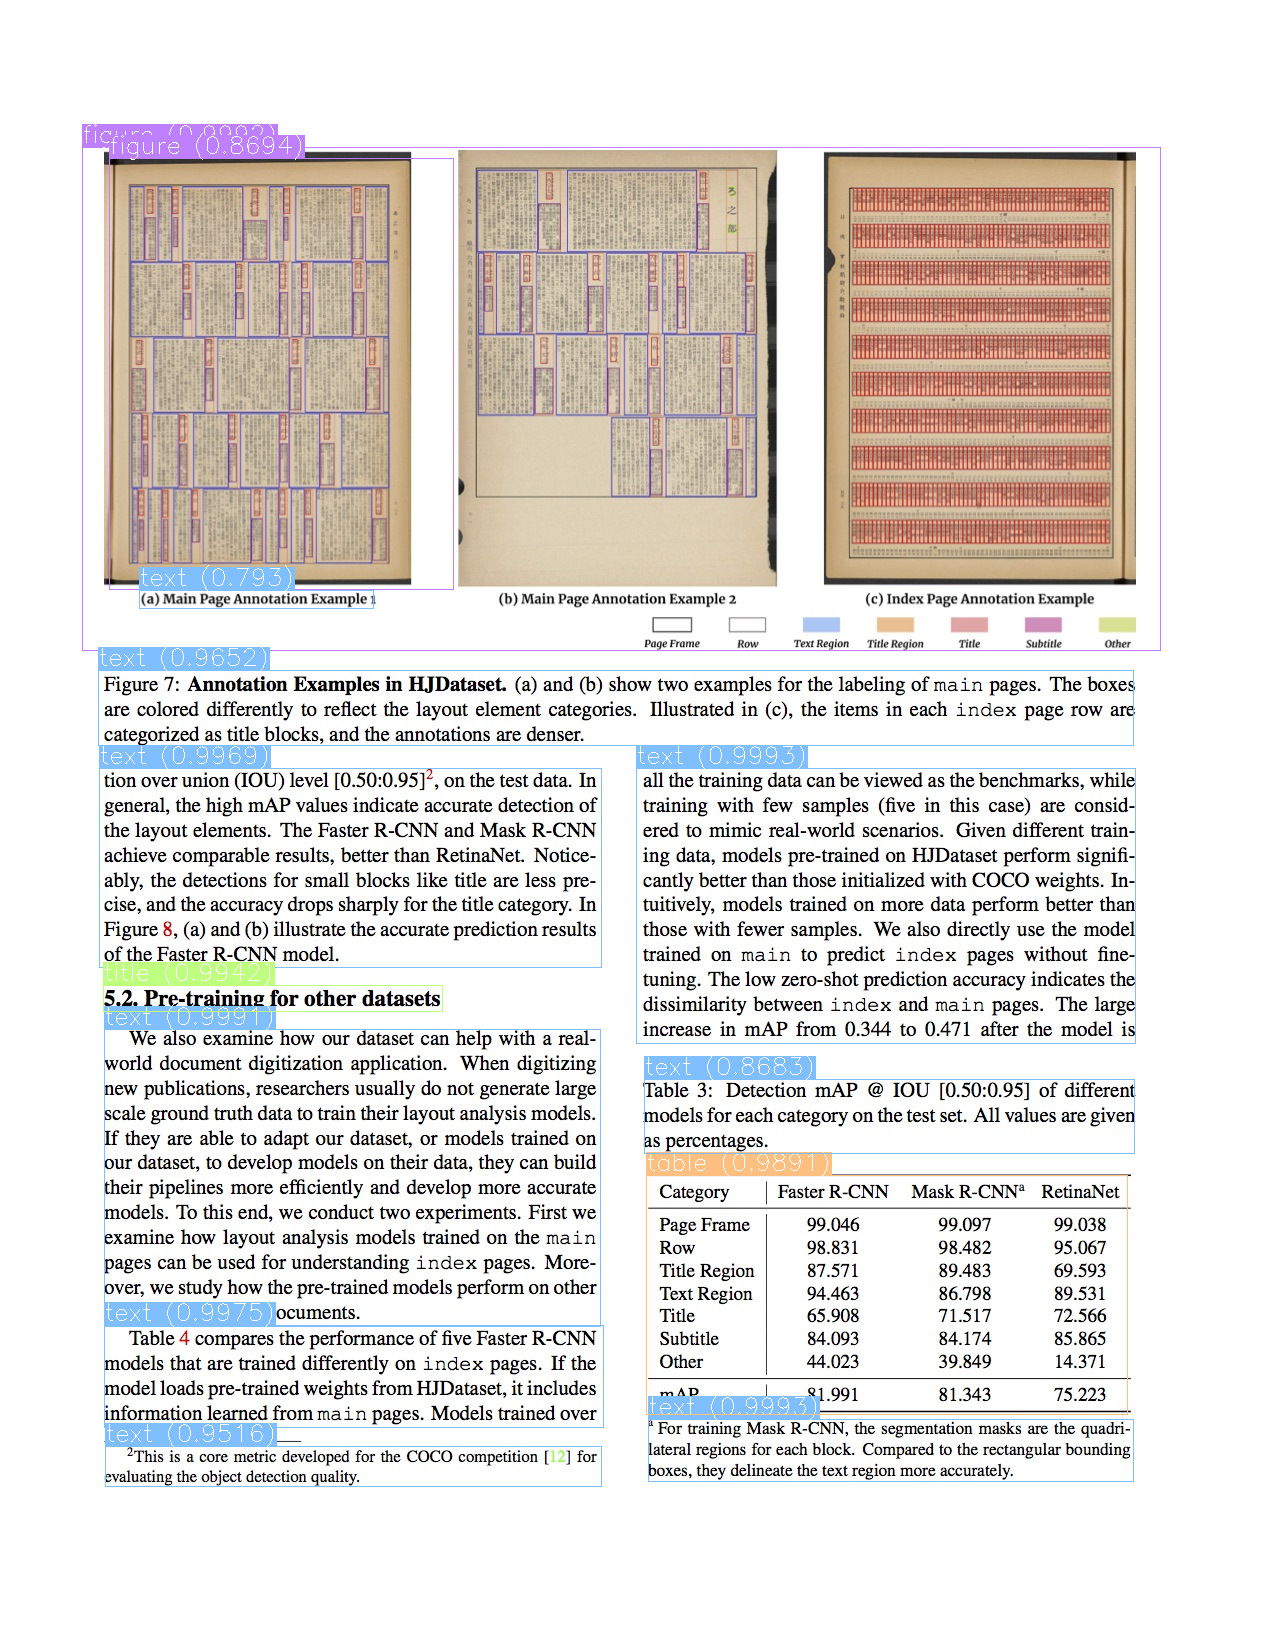

In [ ]:
image = cv2.imread('/content/paper-image.jpg')

color_map = {
    'text': (255, 191, 128),
    'title': (128, 255, 191),
    'list': (191, 128, 255),
    'table': (128, 191, 255),
    'figure': (255, 128, 191)
}

for i in range(0, len(pred_boxes)):
    box = pred_boxes[i].tensor.numpy()[0]
    score = round(float(scores[i].numpy()), 4)
    label_key = int(pred_classes[i].numpy())
    label = class_labels[label_key]

    x = int(box[0])
    y = int(box[1])
    w = int(box[2] - box[0])
    h = int(box[3] - box[1])

    color = color_map.get(label, (0, 0, 0))
    border_size = 1
    cv2.rectangle(image, (x, y), (x + w, y + h), color, border_size)
    font_size = 0.8

    label_text = f"{label} ({score})"
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_size, 1)
    cv2.rectangle(image, (x, y - label_size[1] - 5), (x + label_size[0], y), color, -1)  # Draw background
    cv2.putText(image, label_text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), 1)  # White text

cv2_imshow(image)